# Surfs Up: Climate Analysis of Hawaii Weather using SQLAlchemy, Flask

UCIRV201902DATA3 <br>
Submitted by K. Harrison <br>
30-APR-2019

In [215]:
# Import Dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [216]:
#Reflect tables into SQLAlchemy ORM (credit: starter code)
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model, reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

print(f'Classes in database: {Base.classes.keys()}')

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

Classes in database: ['measurement', 'station']


## Set Trip Dates
Select the dates for trip to Hawaii in "YYYY-MM-DD" format.

In [217]:
#Set trip start and end dates
trip_start_str = '2018-05-28'
trip_end_str = '2018-06-05'

## Create Functions Used for Date Calculations

In [218]:
#calculate 1 year ago from trip dates
def previous_year_date(date):
    year = date[:4]
    month = date[5:7]
    day = date[8:10]
    year_ago = dt.date(int(year), int(month), int(day)) - dt.timedelta(days=365)
    return(year_ago.strftime("%Y-%m-%d"))

def date_to_string(date_as_list):
    for date in date_as_list:
        year=date[:4]
        month=date[5:7]
        day=date[8:10]
    return(f'{year}-{month}-{day}')

In [219]:
trip_start=previous_year_date(trip_start_str)
trip_end=previous_year_date(trip_end_str)

## Exploratory Climate Analysis

In [220]:
#define function to inspect classes
def inspect_classes(class_name):
    inspector = inspect(engine)
    columns = inspector.get_columns(class_name)
    for c in columns:
        print(c)

print("Inspection of 'measurement' class:")       
inspect_classes('measurement')
print("\nInspection of 'station' class")
inspect_classes('station')

Inspection of 'measurement' class:
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}

Inspection of 'station' class
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT

In [221]:
#Determine last date in database using query
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#user np.ravel to unpack the string
last_date_string = list(np.ravel(last_date))

#convert date to string
last_date = date_to_string(last_date_string)

# #slice elements of date string
# for date in last_date_string:
#     year = int(date[:4])
#     month = int(date[5:7])
#     day = int(date[8:10])

#calculate the day 1 year from last day in the database.
year_ago = dt.date(year, month, day) - dt.timedelta(days=365)

year_ago = previous_year_date(date_to_string(last_date_string))

#print dates
print(f'The last date in the database is {year}-{month}-{day}.')
print(f'One year from the last day in the database is {year_ago}.')



The last date in the database is 2017-8-23.
One year from the last day in the database is 2016-08-23.


## Precipitation Analysis

In [222]:
#Query the percipitation amounts for the last year of data
percip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

#ravel query results
percip_results = list(np.ravel(percip))

#store elements from results into invidivual lists
date = [result[0] for result in percip]
prcp = [result[1] for result in percip]

#create dictionary from lists
dict_df = {'date': date, 'precipitation': prcp}

#convert to data frame
df = pd.DataFrame(dict_df)
df1 = df.set_index('date')
df2 = df1.dropna()

#print summary statistics for precipitation data over the last year
df2.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


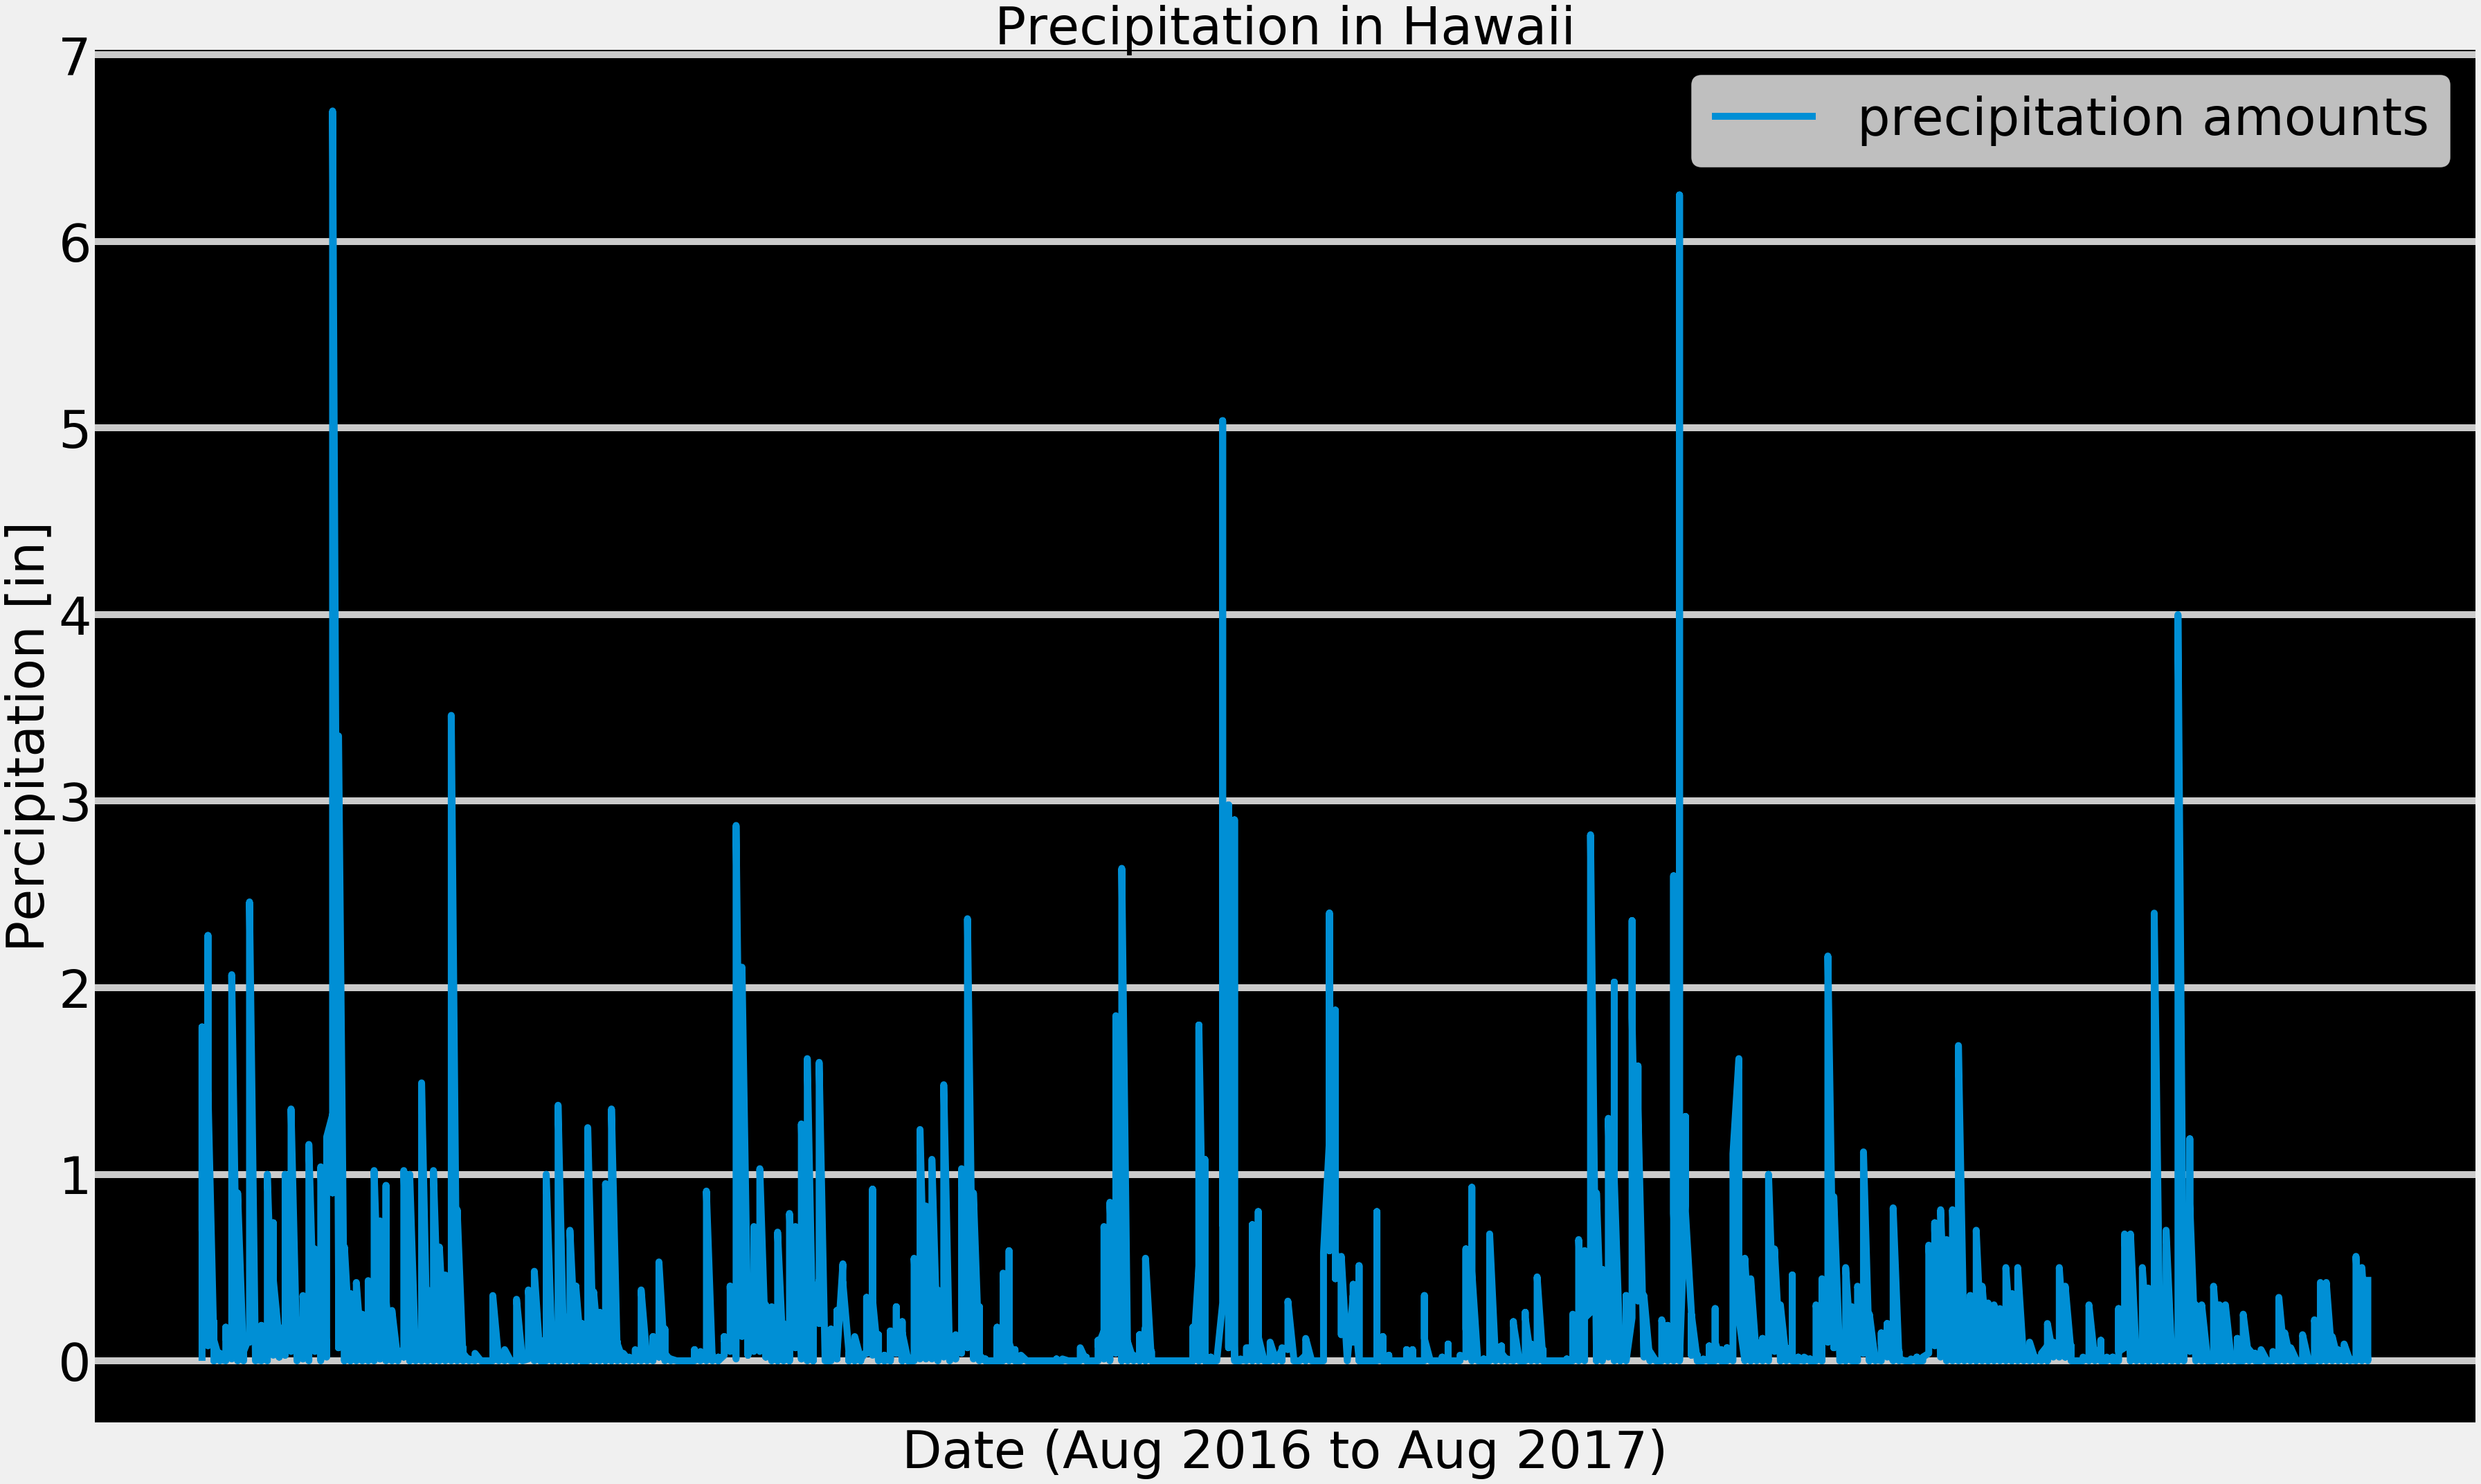

In [223]:
#plot precipitation data
#set size info
figsize=(50,30)
fontsize=75
linewidth=10

#plot data, format
fig, ax = plt.subplots(figsize=figsize)
ax.plot(df2, label = 'precipitation amounts', linewidth=linewidth)
ax.legend(fontsize=fontsize)
ax.xaxis.set_ticklabels([])
ax.tick_params(labelsize=fontsize)
ax.set_title('Precipitation in Hawaii', fontsize=fontsize)
ax.patch.set_facecolor('black')
plt.xlabel('Date (Aug 2016 to Aug 2017)', fontsize=fontsize)
plt.ylabel('Percipitation [in]', fontsize=fontsize)
plt.grid(b=True, which='major', axis='y', linewidth=linewidth)
plt.grid(b=False, which='major', axis='x')

#show figure and save
plt.tight_layout()
plt.savefig('figures/precipitationamounts.png')
plt.show()

## Station Analysis

In [224]:
#Determine number of stations in the database
station_count = session.query(Station.id).all()
print(f"There are {len(station_count)} stations in the database.")

There are 9 stations in the database.


In [225]:
#Query to determine the most active stations based on counts of measurements
sel = [Measurement.station, func.count(Measurement.date)]
active_stations = session.query(*sel).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

print('Active Stations and Counts:')
active_stations

Active Stations and Counts:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [226]:
#Calculate temperature statistics for most active stattion

#store most active station
most_active_station = active_stations[0][0]

#query stats
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
temp_stats = session.query(*sel).filter(Measurement.station == most_active_station).group_by(Measurement.station).all()

#ravel results
temp_stats2 = list(np.ravel(temp_stats))
print(f"Station Name: {temp_stats2[0]}\nMinimum Temp: {temp_stats2[1]} deg F")
print(f"Maximum Temp: {temp_stats2[2]} deg F\nAverage Temp: {temp_stats2[3]} deg F")

Station Name: USC00519281
Minimum Temp: 54.0 deg F
Maximum Temp: 85.0 deg F
Average Temp: 71.66378066378067 deg F


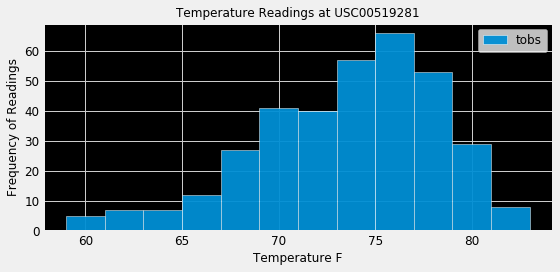

In [227]:
#create histogram

temp_histo = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281", Measurement.date >= '2016-08-23').all()

#store max and minimum temps
max_temp = max(temp_histo)
min_temp = min(temp_histo)

histo = list(np.ravel(temp_histo))

#plot histogram
figsize=(8,4)
fontsize=12
linewidth=10
fig2, ax2 = plt.subplots(figsize=figsize)
ax2.hist(histo, bins=12, label='tobs', edgecolor='white', alpha=.95)
ax2.legend(fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax2.set_title('Temperature Readings at USC00519281', fontsize=fontsize)
ax2.patch.set_facecolor('black')
plt.xlabel('Temperature F', fontsize=fontsize)
plt.ylabel('Frequency of Readings', fontsize=fontsize)
plt.grid(b=True, which='both', axis='both', linewidth=1)
plt.tight_layout()
plt.savefig('figures/temperaturehistogram.png')
plt.show()

## Temperature Analysis

In [228]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates (credit: starter code)
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [229]:
#call calc_temps function for start date, end date
trip_temps = list(np.ravel(calc_temps(trip_start, trip_end)))

#store individual temps
for i in trip_temps:
    tmin = trip_temps[0]
    tave = trip_temps[1]
    tmax = trip_temps[2]

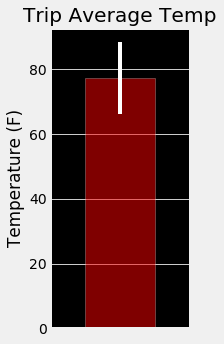

In [230]:
#plot temperature analysis
figsize=(3,5)
bar_width=1

fig3, ax3 = plt.subplots(figsize=figsize)
yerr=tmax-tmin
x = 0

ax3.xaxis.set_ticklabels([])
ax3.bar(x, tave, bar_width, yerr=yerr, alpha=.5, ecolor='white', edgecolor='white', color='red')
ax3.set_title('Trip Average Temp')
ax3.set_xlim(-1, 1)

plt.ylabel('Temperature (F)')
ax3.patch.set_facecolor('black')
plt.grid(b=True, which='major', axis='y')
plt.grid(b=False, which='major', axis='x')
fig3.tight_layout()
plt.savefig('figures/temperatureanalysis.png')
plt.show()

## Daily Rainfall Totals

In [231]:
#Calculate total amount of rainfull per weather station during trip dates of previous year
sel = [Station.station, Station.name, Station.latitude, Station.longitude,\
       Station.elevation, func.sum(Measurement.prcp)]

#query rainfall amounts
rain = session.query(*sel).\
    filter(Measurement.date >= trip_start, Measurement.date <= trip_end).\
    filter(Measurement.station == Station.station).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

print(rain)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.1999999999999997), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.0899999999999999), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.84), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.44), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.32000000000000006), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.26), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Daily Normal Temperatures

In [232]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
# credit: starter code

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [233]:
#grab info from trip dates
year_start = trip_start[:4]
month_start = trip_start[5:7]
day_start = trip_start[8:10]
year_end = trip_end[:4]
month_end = trip_end[5:7]
day_end = trip_end[8:10]

#convert to datetime format
trip_start_dt = dt.datetime.strptime(trip_start, "%Y-%m-%d")
trip_end_dt = dt.datetime.strptime(trip_end, "%Y-%m-%d")

#calculate number of days in trip (add 1 so it is inclusive)
trip_dates_dt = [trip_start_dt + dt.timedelta(days=x) for x in range(0, (trip_end_dt-trip_start_dt).days+1)]

#create list for days in trip in month-day format
trip_dates_str = []
for date in trip_dates_dt:
    trip_dates_str.append(date.strftime("%m-%d"))
    
#create list to store normals
normals = []

#call on function to calculate normals for all days
for date in trip_dates_str:
    normals.append(daily_normals(date))

#ravel normals
normals_ravel = list(np.ravel(normals))

#store min, max, and average as variables
normal_tmin = normals_ravel[0::3]
normal_tave = normals_ravel[1::3]
normal_tmax = normals_ravel[2::3]

#create dictionary with data, convert to dataframe
normals_dict = {'date': trip_dates_str, "tmin": normal_tmin, 'tave': normal_tave, 'tmax': normal_tmax}
normals_df = pd.DataFrame(normals_dict)
normals_df = normals_df.set_index('date')
normals_df

,tave,tmax,tmin
date,,,
05-28,74.277778,82.0,67.0
05-29,74.196078,80.0,64.0
05-30,74.333333,81.0,69.0
05-31,74.400000,81.0,68.0
06-01,74.614035,81.0,64.0
06-02,74.400000,81.0,65.0
06-03,74.034483,80.0,65.0
06-04,73.818182,81.0,65.0
06-05,74.854545,81.0,68.0


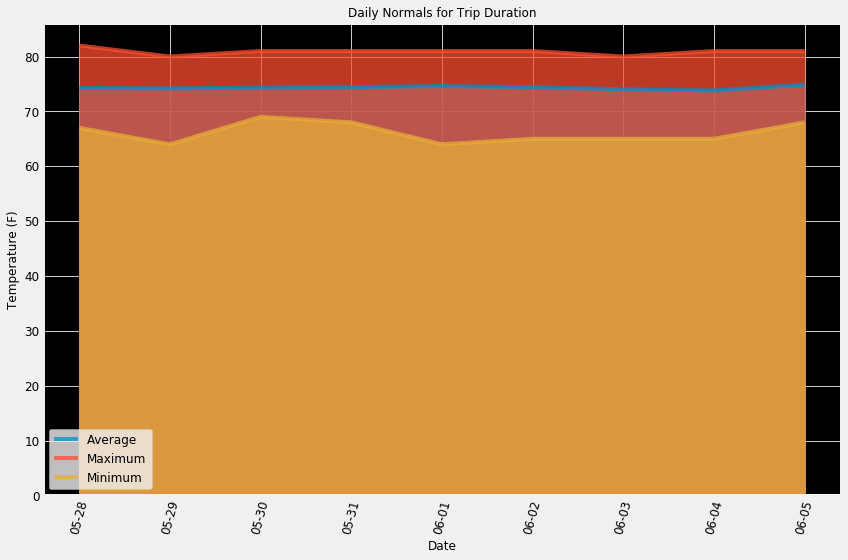

In [214]:
#plot daily normals
x_axis = np.arange(len(trip_dates_str))
figsize=(12,8)

labels = ['Average', 'Maximum', 'Minimum']

ax4 = normals_df.plot.area(stacked=False, alpha=.75, figsize=figsize)

ax4.set_xticks(x_axis)
ax4.set_xticklabels(trip_dates_str, rotation=75)
ax4.legend(fontsize=fontsize, labels=labels)
ax4.tick_params(labelsize=fontsize)
ax4.set_title('Daily Normals for Trip Duration', fontsize=fontsize)
ax4.patch.set_facecolor('black')
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Temperature (F)', fontsize=fontsize)
plt.grid(b=True, which='both', axis='both', linewidth=1)
plt.tight_layout()
plt.savefig('figures/dailytempnormals')
plt.show()

End of Analysis